# Предсказание значении котировок акций компании Apple (AAPL, биржа NASDAQ)

### Импорт библиотек

In [1]:
#!pip install pmdarima
#!pip install lightgbm
#!pip install sklearn

In [2]:
import math
import os
import sys
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from time import time
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from collections import defaultdict
from lightgbm import LGBMRegressor

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Загрузка данных

Исходя из задания необходимо получить значения котировок акций компании Apple (AAPL, биржа NASDAQ) и написать модель предсказания движения цены или вер-ть движения цены вверх или вниз за следующий период.

В массивах данных хранятся значения open (цена открытия в текущем таймфрейме), high (максимальная цена), low (минимальная цена), close (цена закрытия) и volume (объем сделок данного актива) и т д.

На вход программе будем подать не менее 2-х параметров. Интервал выбран 15 минут с 31.08.20 по 31.08.21.

In [3]:
df = pd.read_csv("US1.AAPL_200831_210831.csv", sep=";")
df.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,US1.AAPL,15,08/31/20,1645,127.50,128.45,126.35,128.28,839694
1,US1.AAPL,15,08/31/20,1700,128.33,128.50,127.45,128.03,580865
2,US1.AAPL,15,08/31/20,1715,128.03,128.28,127.14,127.93,403966
3,US1.AAPL,15,08/31/20,1730,127.95,128.49,127.77,128.24,442410
4,US1.AAPL,15,08/31/20,1745,128.23,128.75,127.85,128.16,470903


In [4]:
# убираем заглавный шрифт и лишние символы в название столбцов
new_columns = []
for i in df.columns:
    new_columns.append(i.lower().replace("<", "").replace(">", ""))
df.columns = new_columns

### Предварительный анализ данных
Смотрим описательные характеристики тренировочного датасета

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  6573 non-null   object 
 1   per     6573 non-null   int64  
 2   date    6573 non-null   object 
 3   time    6573 non-null   int64  
 4   open    6573 non-null   float64
 5   high    6573 non-null   float64
 6   low     6573 non-null   float64
 7   close   6573 non-null   float64
 8   vol     6573 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 462.3+ KB


In [6]:
df.isna().sum(0)

ticker    0
per       0
date      0
time      0
open      0
high      0
low       0
close     0
vol       0
dtype: int64

In [7]:
df.describe()

,per,time,open,high,low,close,vol
count,6573.0,6573.000000,6573.000000,6573.000000,6573.000000,6573.000000,6.573000e+03
mean,15.0,1973.855165,128.695434,128.947668,128.419767,128.693472,1.878637e+05
std,0.0,303.481375,10.814094,10.781828,10.856318,10.820222,1.546849e+05
min,15.0,0.000000,104.510000,105.580000,103.110000,105.020000,1.000000e+02
25%,15.0,1830.000000,120.550000,120.820000,120.290000,120.560000,9.177000e+04
50%,15.0,2015.000000,127.300000,127.480000,127.090000,127.300000,1.380240e+05
75%,15.0,2145.000000,134.700000,134.890000,134.450000,134.690000,2.254680e+05
max,15.0,2345.000000,153.410000,153.490000,153.180000,153.420000,1.600596e+06


In [8]:
df["ticker"].value_counts()

US1.AAPL    6573
Name: ticker, dtype: int64

### Выводы:
в наборе 6573 строк о цене акции. Всего 9 переменных:

'date' - временная переменная;

'ticker' - категориальные переменная;

'time', 'per', 'open', 'high', 'low', 'close', 'vol' - числовые переменные;

default - целевая переменная, индикатор дефолта.


Всего пропусков: 0.

### Преобразование временной переменной

In [9]:
df = df.drop(np.where(df["time"] == 0)[0])
df["time"] = df["time"].astype(str)
df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m/%d/%y %H%M")
df = df.set_index('datetime')
df.head()

,ticker,per,date,time,open,high,low,close,vol
datetime,,,,,,,,,
2020-08-31 16:45:00,US1.AAPL,15,08/31/20,1645,127.50,128.45,126.35,128.28,839694
2020-08-31 17:00:00,US1.AAPL,15,08/31/20,1700,128.33,128.50,127.45,128.03,580865
2020-08-31 17:15:00,US1.AAPL,15,08/31/20,1715,128.03,128.28,127.14,127.93,403966
2020-08-31 17:30:00,US1.AAPL,15,08/31/20,1730,127.95,128.49,127.77,128.24,442410
2020-08-31 17:45:00,US1.AAPL,15,08/31/20,1745,128.23,128.75,127.85,128.16,470903


### Удаляем малозначительные и признаки на основе которых были созданы новые

In [10]:
drop = ["ticker", "per", "time", "date"]
df = df.drop(drop, axis=1)

### Рассмотрим график цены закрытия акции на протяжении года.

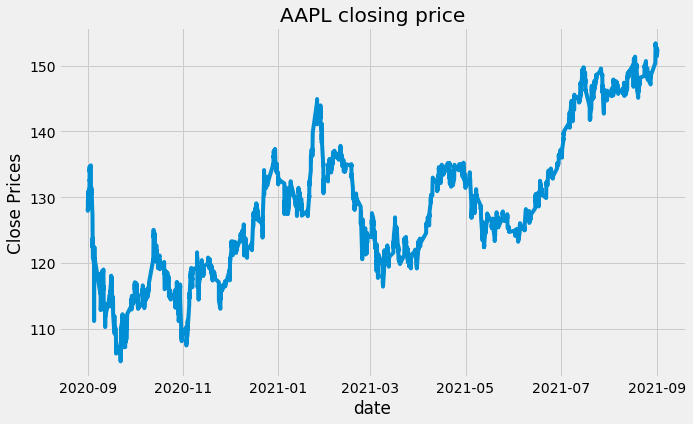

In [11]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('AAPL closing price')
plt.show()

### Мы также можем визуализировать данные с помощью распределения вероятностей.

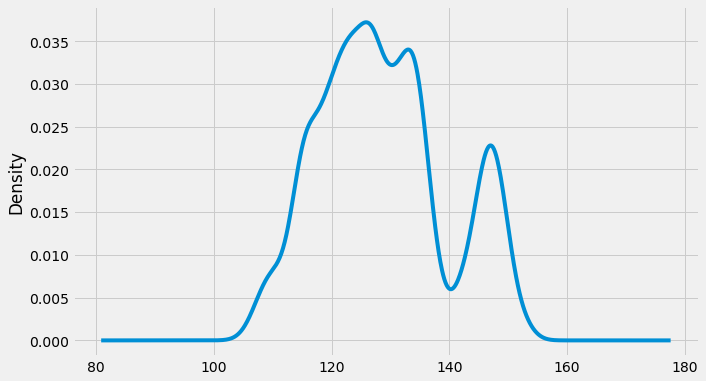

In [12]:
df.close.plot(kind='kde')


Нужно проверить, является ли ряд стационарным или нет, потому что анализ временных рядов работает только со стационарными данными.



### Проверим стационарность:

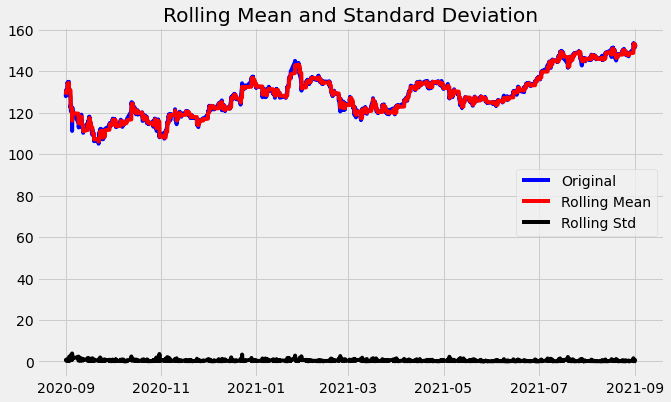

Results of dickey fuller test
Test Statistics                  -0.940255
p-value                           0.774427
No. of lags used                 27.000000
Number of observations used    6457.000000
critical value (1%)              -3.431363
critical value (5%)              -2.861988
critical value (10%)             -2.567008
dtype: float64


In [13]:

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df.close)

На приведенном выше графике мы видим увеличение среднего и стандартного отклонения, и, следовательно, наш ряд не является стационарным.

### Отделим тенденцию и сезонность от временных рядов.

<Figure size 720x432 with 0 Axes>

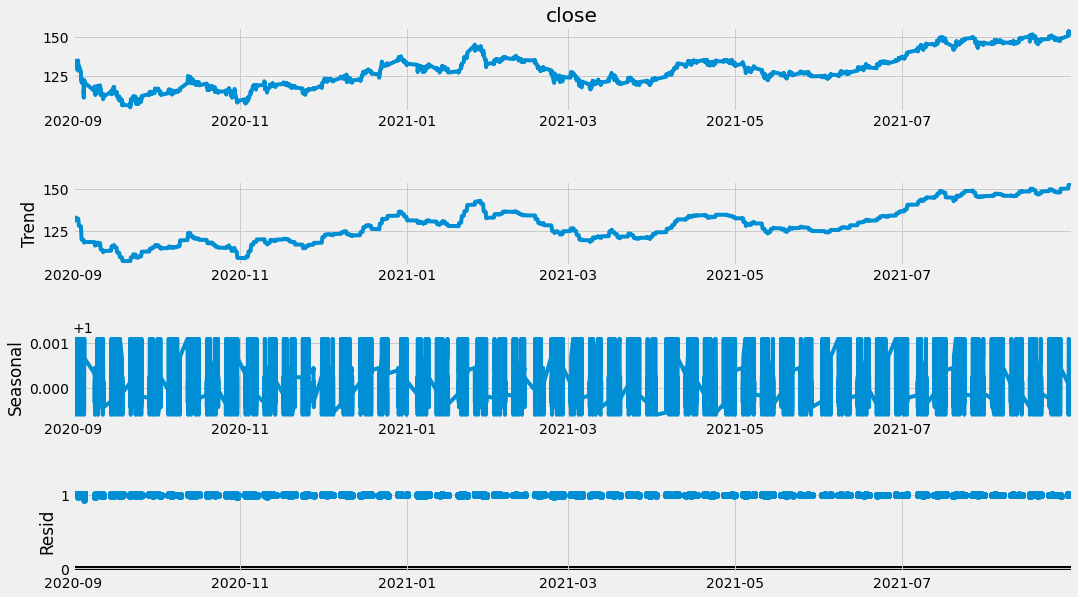

In [14]:
result = seasonal_decompose(df.close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


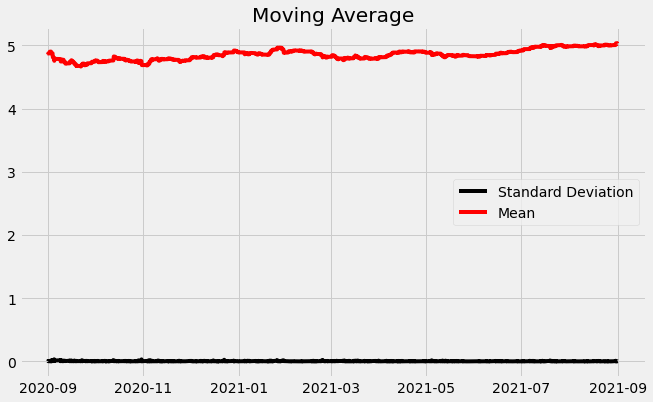

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df.close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

### Создание модели ARIMA и обучение ее цене закрытия акций по обучающим данным

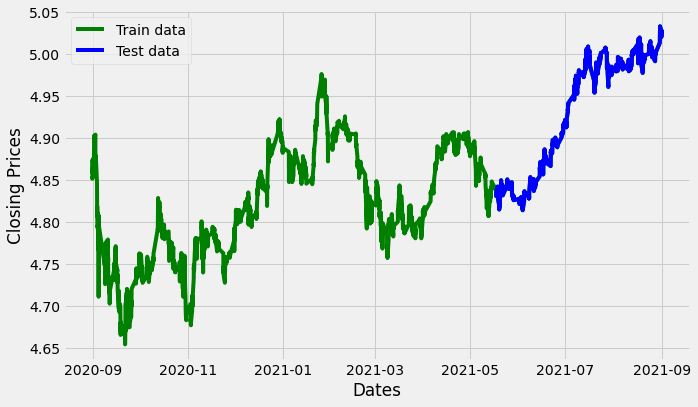

In [16]:
coef_tr_te = 0.7
train_data, test_data = df_log[3:int(len(df_log)*coef_tr_te)], df_log[int(len(df_log)*coef_tr_te):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Выбираем параметры p,q,d для модели ARIMA

### Автоматическое определение оптимальных пареметров для модели ARIMA.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36725.866, Time=1.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36724.946, Time=0.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36724.981, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36727.862, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36723.474, Time=2.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 4.976 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 4536
Model:               SARIMAX(0, 1, 0)   Log Likelihood               18364.931
Date:                Fri, 10 Sep 2021   AIC                         -36727.862
Time:                        16:25:56   BIC                         -36721.443
Sample:                             0   HQIC                        -36725.601
                               - 4536                             

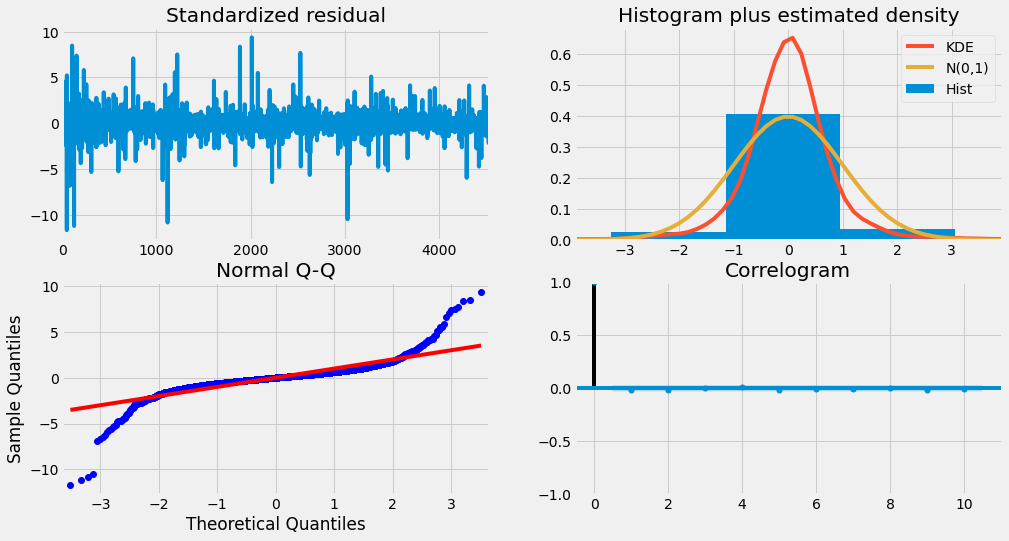

In [17]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=None,           
                      seasonal=False,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Вверху слева**: Остаточные ошибки, по-видимому, колеблются вокруг среднего значения, равного нулю, и имеют равномерную дисперсию.


**Вверху справа**: График плотности предполагает нормальное распределение со средним нулем.


**Слева внизу**: Все точки должны идеально совпадать с красной линией. Любые значительные отклонения означали бы, что распределение искажено.


**Внизу справа**: Коррелограмма, она же график ACF, показывает, что остаточные ошибки не являются автокоррелированными. Любая автокорреляция будет означать, что в остаточных ошибках есть какая-то закономерность, которая не объясняется в модели. Поэтому вам нужно будет найти больше X (предикторов) для модели.

#### Таким образом, модель Auto ARIMA предоставила значения p,d и q как 0, 1 и 0 соответственно.

In [18]:
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 4535
Model:                 ARIMA(0, 1, 0)   Log Likelihood               18364.933
Method:                           css   S.D. of innovations              0.004
Date:                Fri, 10 Sep 2021   AIC                         -36725.866
Time:                        16:25:57   BIC                         -36713.027
Sample:                             1   HQIC                        -36721.344
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.061e-06   6.26e-05     -0.065      0.948      -0.000       0.000


C:\Users\Ruslan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Ruslan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


### Прогноз цены акций в тестовом наборе данных, сохраняя уровень достоверности 70%.

In [19]:
fc, se, conf = fitted.forecast(1946, alpha=0.05)

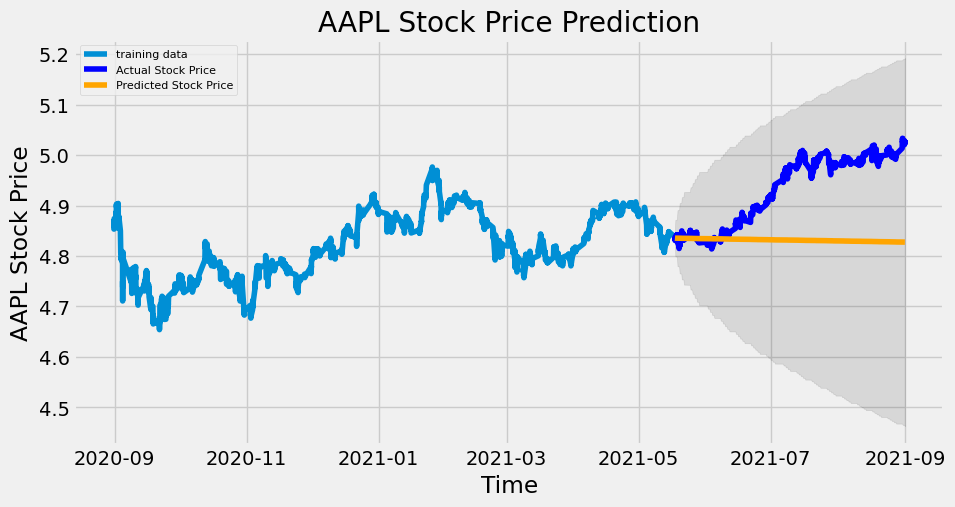

In [20]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [21]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.015238667892954189
MAE: 0.10254357501065428
RMSE: 0.1234449994651634
MAPE: 0.020598547346889495


**Как вы можете видеть, на больших временных промежутках наша модель выводит данные без тренда. Попробуем сделать дополнительную обработку данных и использовать другие модели.**

### Добавление новых признаков на основание данных

In [22]:
data_columns = ['open', 'high', 'low','close','vol']

In [23]:
def train_test_split(df, date_split):
    date_split = pd.to_datetime(date_split)
    msk_train = df.index < date_split
    train_df = df[msk_train]
    test_df = df[~msk_train]
    
    #print(len(train_df), len(test_df))
    
    return train_df, test_df



def feat_extr(df):
    lst_df = []
    for agg in ['mean', 'max']:
        for dttm in np.array([1, 2])+1:
            #print(dttm)
            if agg=='mean':
                a = df[data_columns].rolling(dttm, closed='left').mean()
            elif agg=='sum':
                a = df[data_columns].rolling(dttm, closed='left').sum()
            elif agg=='max':
                a = df[data_columns].rolling(dttm, closed='left').max()
            elif agg=='median':
                a = df[data_columns].rolling(dttm, closed='left').median()
            
            a.columns = [col[:4] +str(dttm-1) + '_' + agg for col in data_columns]
            lst_df.append(a)
            #print(a.columns)
    return lst_df

def get_time_feats(df):
    df['day'] = df.index.isocalendar()['day'].astype(int)
    hours = df.index.hour
    minutes = hours*60 + df.index.minute
    df['hour'] = hours
    df['minutes'] = minutes
    df['month'] = df.index.month
    return df

def get_features(df):
    lst_df = feat_extr(df)
    df_n = df
    for feat_df in lst_df:
        df_n = pd.merge(df_n, feat_df, left_index=True, right_index=True)
    get_time_feats(df_n)
    return df_n

### Прогноз цены акций в тестовом наборе данных, сохраняя уровень достоверности 70%.

In [24]:
train, test = train_test_split(df, '2021-06-01')

In [25]:
test

,open,high,low,close,vol
datetime,,,,,
2021-06-01 16:45:00,125.08,125.35,124.74,124.92,350689
2021-06-01 17:00:00,124.92,125.01,124.45,124.65,233839
2021-06-01 17:15:00,124.64,124.70,124.14,124.14,129326
2021-06-01 17:30:00,124.13,124.64,123.94,124.64,156253
2021-06-01 17:45:00,124.64,124.81,124.52,124.60,198180
...,...,...,...,...,...
2021-08-31 22:00:00,152.36,152.38,152.21,152.36,107681
2021-08-31 22:15:00,152.37,152.41,152.10,152.16,99140
2021-08-31 22:30:00,152.16,152.24,151.96,151.96,142185


In [26]:
train

,open,high,low,close,vol
datetime,,,,,
2020-08-31 16:45:00,127.50,128.45,126.350,128.28,839694
2020-08-31 17:00:00,128.33,128.50,127.450,128.03,580865
2020-08-31 17:15:00,128.03,128.28,127.140,127.93,403966
2020-08-31 17:30:00,127.95,128.49,127.770,128.24,442410
2020-08-31 17:45:00,128.23,128.75,127.850,128.16,470903
...,...,...,...,...,...
2021-05-28 22:00:00,125.08,125.14,125.010,125.08,69617
2021-05-28 22:15:00,125.07,125.10,124.940,124.96,104152
2021-05-28 22:30:00,124.96,125.11,124.945,125.05,96749


In [27]:
train_feats = get_features(train).iloc[30:]
test_feats = get_features(test).iloc[30:]

In [28]:
train_feats

,open,high,low,close,vol,open1_mean,high1_mean,low1_mean,clos1_mean,vol1_mean,...,vol1_max,open2_max,high2_max,low2_max,clos2_max,vol2_max,day,hour,minutes,month
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-01 17:45:00,131.82,132.20,131.510,131.68,165290,131.275,131.985,130.8200,131.360,241627.5,...,302881.0,131.65,132.07,130.940,131.81,355596.0,2,17,1065,9
2020-09-01 18:00:00,131.66,132.00,131.590,131.77,108162,131.360,132.050,131.1800,131.745,172832.0,...,180374.0,131.82,132.20,131.510,131.81,302881.0,2,18,1080,9
2020-09-01 18:15:00,131.78,132.47,131.760,132.47,159814,131.740,132.100,131.5500,131.725,136726.0,...,165290.0,131.82,132.20,131.590,131.81,180374.0,2,18,1095,9
2020-09-01 18:30:00,132.45,132.65,131.940,132.35,194312,131.720,132.235,131.6750,132.120,133988.0,...,159814.0,131.82,132.47,131.760,132.47,165290.0,2,18,1110,9
2020-09-01 18:45:00,132.36,132.45,131.800,132.01,125849,132.115,132.560,131.8500,132.410,177063.0,...,194312.0,132.45,132.65,131.940,132.47,194312.0,2,18,1125,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-28 22:00:00,125.08,125.14,125.010,125.08,69617,125.005,125.080,124.9550,125.075,61585.0,...,71154.0,125.08,125.08,125.000,125.08,81205.0,5,22,1320,5
2021-05-28 22:15:00,125.07,125.10,124.940,124.96,104152,125.080,125.110,125.0050,125.075,60816.5,...,69617.0,125.08,125.14,125.010,125.08,71154.0,5,22,1335,5
2021-05-28 22:30:00,124.96,125.11,124.945,125.05,96749,125.075,125.120,124.9750,125.020,86884.5,...,104152.0,125.08,125.14,125.010,125.08,104152.0,5,22,1350,5


In [29]:
X_train, y_train = train_feats.drop(columns=data_columns), train_feats['close']
X_test, y_test = test_feats.drop(columns=data_columns), test_feats['close']

In [30]:
X_train.head()

,open1_mean,high1_mean,low1_mean,clos1_mean,vol1_mean,open2_mean,high2_mean,low2_mean,clos2_mean,vol2_mean,...,vol1_max,open2_max,high2_max,low2_max,clos2_max,vol2_max,day,hour,minutes,month
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-01 17:45:00,131.275,131.985,130.820,131.360,241627.5,131.256667,132.000000,130.860000,131.443333,279617.000000,...,302881.0,131.65,132.07,130.94,131.81,355596.0,2,17,1065,9
2020-09-01 18:00:00,131.360,132.050,131.180,131.745,172832.0,131.456667,132.056667,131.050000,131.466667,216181.666667,...,180374.0,131.82,132.20,131.51,131.81,302881.0,2,18,1080,9
2020-09-01 18:15:00,131.740,132.100,131.550,131.725,136726.0,131.460000,132.033333,131.316667,131.753333,151275.333333,...,165290.0,131.82,132.20,131.59,131.81,180374.0,2,18,1095,9
2020-09-01 18:30:00,131.720,132.235,131.675,132.120,133988.0,131.753333,132.223333,131.620000,131.973333,144422.000000,...,159814.0,131.82,132.47,131.76,132.47,165290.0,2,18,1110,9
2020-09-01 18:45:00,132.115,132.560,131.850,132.410,177063.0,131.963333,132.373333,131.763333,132.196667,154096.000000,...,194312.0,132.45,132.65,131.94,132.47,194312.0,2,18,1125,9


In [31]:
y_train

datetime
2020-09-01 17:45:00    131.68
2020-09-01 18:00:00    131.77
2020-09-01 18:15:00    132.47
2020-09-01 18:30:00    132.35
2020-09-01 18:45:00    132.01
                        ...  
2021-05-28 22:00:00    125.08
2021-05-28 22:15:00    124.96
2021-05-28 22:30:00    125.05
2021-05-28 22:45:00    125.04
2021-05-28 23:00:00    124.71
Name: close, Length: 4764, dtype: float64

### Создание модели LGBMR и обучение ее цене закрытия акций по обучающим данным

In [32]:
params = {"num_leaves": 32,
             "learning_rate": 0.01,
             "colsample_bytree": 0.7,
             "subsample": 0.7,
             "n_estimators": 1200,
             "metric": ['mae', 'mse', 'r2'],
        }

boost_model = LGBMRegressor(**params)
boost_model.fit(X_train, y_train,
               eval_set=[(X_train, y_train),
                         (X_test, y_test)],
               eval_metric=['mae', 'mse', 'r2'],
               verbose=100)

[100]	training's l1: 2.42609	training's l2: 8.54392	valid_1's l1: 8.28442	valid_1's l2: 92.1815
[200]	training's l1: 0.953916	training's l2: 1.38995	valid_1's l1: 5.03766	valid_1's l2: 38.4693
[300]	training's l1: 0.464922	training's l2: 0.407108	valid_1's l1: 3.82519	valid_1's l2: 24.6852
[400]	training's l1: 0.335488	training's l2: 0.25472	valid_1's l1: 3.38579	valid_1's l2: 20.3851
[500]	training's l1: 0.303949	training's l2: 0.215301	valid_1's l1: 3.25837	valid_1's l2: 19.157
[600]	training's l1: 0.29056	training's l2: 0.195218	valid_1's l1: 3.20642	valid_1's l2: 18.6308
[700]	training's l1: 0.280378	training's l2: 0.178878	valid_1's l1: 3.19887	valid_1's l2: 18.5456
[800]	training's l1: 0.271658	training's l2: 0.164531	valid_1's l1: 3.18855	valid_1's l2: 18.4329
[900]	training's l1: 0.264516	training's l2: 0.153863	valid_1's l1: 3.19054	valid_1's l2: 18.449
[1000]	training's l1: 0.25816	training's l2: 0.145474	valid_1's l1: 3.20924	valid_1's l2: 18.6358
[1100]	training's l1: 0.252

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.01,
              metric=['mae', 'mse', 'r2'], n_estimators=1200, num_leaves=32,
              subsample=0.7)

### Создание модели LinearRegression и обучение ее цене закрытия акций по обучающим данным

In [33]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [34]:
preds = boost_model.predict(X_test)
preds_reg = lr.predict(X_test)

In [35]:
y_tt = pd.DataFrame(deepcopy(y_test))

In [36]:
y_tt['preds'] = preds
y_tt['preds_reg'] = preds_reg

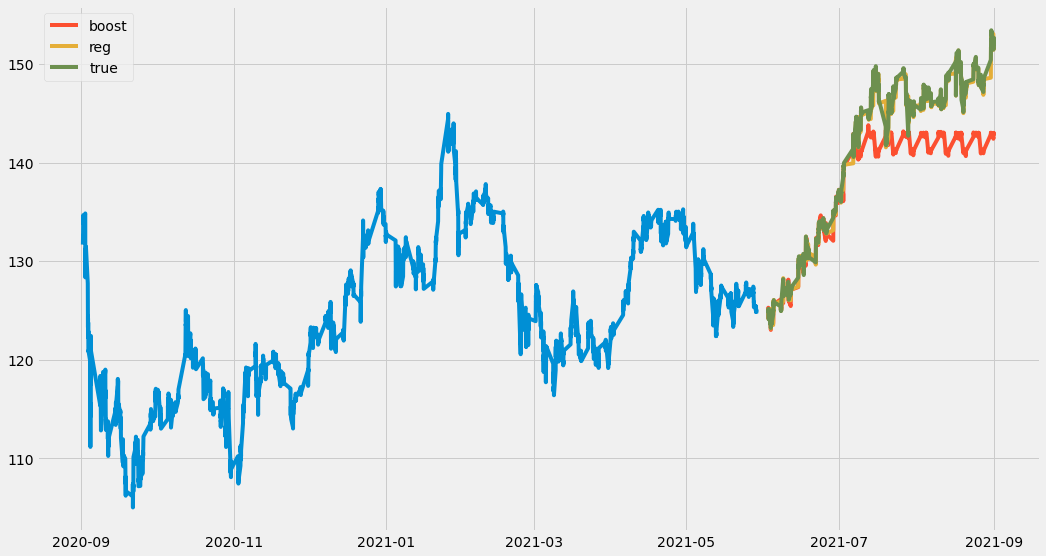

In [37]:
plt.figure(figsize=(16, 9))
plt.plot(y_train)
plt.plot(y_tt['preds'], label='boost')
plt.plot(y_tt['preds_reg'], label='reg')
plt.plot(y_tt['close'], label='true')
plt.legend()

In [38]:
print('Linear Regression')
mse = mean_squared_error(y_tt['preds_reg'], y_tt['close'])
print('MSE: '+str(mse))
mae = mean_absolute_error(y_tt['preds_reg'], y_tt['close'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_tt['preds_reg'], y_tt['close']))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_tt['close'] - y_tt['preds_reg'])/np.abs(y_tt['preds_reg']))
print('MAPE: '+str(mape))


Linear Regression
MSE: 0.12693826765519065
MAE: 0.22428371137775946
RMSE: 0.3562839705279914
MAPE: 0.0015847692460461253


**Как вы можете видеть, При дополнительной обработке данных и использовании моделей lightgbm и LinearRegression предсказания становятся более качественными, а также меняется тренд цены на акцию.**

In [39]:
def train_test_split(df, date_split):
    date_split = pd.to_datetime(date_split)
    msk_train = df.index < date_split
    train_df = df[msk_train]
    test_df = df[~msk_train]
    
    #print(len(train_df), len(test_df))
    
    return train_df, test_df



def feat_extr(df):
    lst_df = []
    for agg in ['mean', 'max']:
        for dttm in np.array([1, 2, 3, 4, 5, 10, 15])+1:
            #print(dttm)
            if agg=='mean':
                a = df[data_columns].rolling(dttm, closed='left').mean()
            elif agg=='sum':
                a = df[data_columns].rolling(dttm, closed='left').sum()
            elif agg=='max':
                a = df[data_columns].rolling(dttm, closed='left').max()
            elif agg=='median':
                a = df[data_columns].rolling(dttm, closed='left').median()
            
            a.columns = [col[:4] +str(dttm-1) + '_' + agg for col in data_columns]
            lst_df.append(a)
            #print(a.columns)
    return lst_df


In [40]:
df.rolling(2, closed='left').mean()

,open,high,low,close,vol
datetime,,,,,
2020-08-31 16:45:00,NaN,NaN,NaN,NaN,NaN
2020-08-31 17:00:00,NaN,NaN,NaN,NaN,NaN
2020-08-31 17:15:00,127.915,128.475,126.900,128.155,710279.5
2020-08-31 17:30:00,128.180,128.390,127.295,127.980,492415.5
2020-08-31 17:45:00,127.990,128.385,127.455,128.085,423188.0
...,...,...,...,...,...
2021-08-31 22:00:00,152.365,152.525,152.300,152.405,76126.5
2021-08-31 22:15:00,152.415,152.470,152.280,152.355,95400.0
2021-08-31 22:30:00,152.365,152.395,152.155,152.260,103410.5


In [41]:
df

,open,high,low,close,vol
datetime,,,,,
2020-08-31 16:45:00,127.50,128.45,126.35,128.28,839694
2020-08-31 17:00:00,128.33,128.50,127.45,128.03,580865
2020-08-31 17:15:00,128.03,128.28,127.14,127.93,403966
2020-08-31 17:30:00,127.95,128.49,127.77,128.24,442410
2020-08-31 17:45:00,128.23,128.75,127.85,128.16,470903
...,...,...,...,...,...
2021-08-31 22:00:00,152.36,152.38,152.21,152.36,107681
2021-08-31 22:15:00,152.37,152.41,152.10,152.16,99140
2021-08-31 22:30:00,152.16,152.24,151.96,151.96,142185


In [42]:
pd.DataFrame({'test':[1,1,3,1,1,4]})

,test
0,1
1,1
2,3
3,1
4,1
5,4


In [43]:
pd.DataFrame({'test':[1,1,3,1,1,4]}).rolling(3,closed='left').mean()

,test
0,NaN
1,NaN
2,NaN
3,1.666667
4,1.666667
5,1.666667


In [44]:
pd.DataFrame({'test':[1,1,3,1,1,4]}).rolling(3).mean()

,test
0,NaN
1,NaN
2,1.666667
3,1.666667
4,1.666667
5,2.000000


In [46]:
# проверка значимости коефициентов линейной регресси
import statsmodels.api as sm  
sm.add_constant(X_train, prepend=False)
ols_reg = sm.OLS(y_train, sm.add_constant(X_train, prepend=False))
reg = ols_reg.fit()
print(reg.summary())
reg.pvalues[reg.pvalues<0.05].index

                            OLS Regression Results                            
Dep. Variable:                  close   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 4.395e+04
Date:                Fri, 10 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:35:59   Log-Likelihood:                -3692.2
No. Observations:                4764   AIC:                             7434.
Df Residuals:                    4739   BIC:                             7596.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
open1_mean    -0.3582      0.124     -2.894      0.0

Index(['open1_mean', 'high1_mean', 'low1_mean', 'clos1_mean', 'high1_max',
       'low1_max', 'clos1_max', 'open2_max', 'high2_max', 'low2_max'],
      dtype='object')